# Teraherz Absorber Prediction with ML

## 1.1 Random Forest

In [1]:
import multiprocessing
print(multiprocessing.cpu_count())

20


In [2]:
!pip install joblib


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = r"C:\Users\23081\Desktop\THz.xlsx"
df = pd.read_excel(file_path)

Data Cleaning

In [4]:
# Check missing values
if df.isnull().sum().sum() > 0:
    print("Handling missing values...")
    df = df.fillna(df.mean())  # fill as mean value

# First 6 columns as input, last 2 columns output
X = df.iloc[0:531, :6]
y = df.iloc[0:531, 6:8]

# Check again
if X.isnull().sum().sum() > 0 or y.isnull().sum().sum() > 0:
    print("Data still contains missing values after preprocessing.")
else:
    print("Missing values handled.")
    
# Standardizing the feature set X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Handling missing values...
Missing values handled.


Model Training

In [5]:

# Use Random Forest model for training
models = {}
predictions = {}
metrics = {}
r2_scores = {}
output_data = {}

for column in y.columns:
    # Check Classification or Regression    
    if y[column].nunique() <= 2:  
        model = RandomForestClassifier(n_estimators=100, random_state=20)
    else:  
        model = RandomForestRegressor(n_estimators=100, random_state=20)
    
    # Model training
    model.fit(X_train, y_train[column])
    models[column] = model
    
    # Predicting
    y_pred = model.predict(X_test)
    predictions[column] = y_pred
    
    # Evaluation
    if isinstance(model, RandomForestClassifier):
        metrics[column] = accuracy_score(y_test[column], y_pred)
    else:
        metrics[column] = mean_squared_error(y_test[column], y_pred)
    
    # Calculating R²
    r2 = r2_score(y_test[column], y_pred)
    r2_scores[column] = r2

    # Store actual values and predicted values
    output_data[column] = pd.DataFrame({
        'Actual': y_test[column].values,
        'Predicted': y_pred
    })


Output and Evaluation

In [6]:
# Evaluation Metrics
print("\nFinal Evaluation Metrics:")
for output, metric in metrics.items():
    eval_type = "Accuracy" if y[output].nunique() <= 2 else "MSE"
    print(f"{output} - {eval_type}: {metric:.4f}, R²: {r2_scores[output]:.4f}")

# Actual values and predicted values
print("\nPredicted vs Actual Values:")
for column in y.columns:
    print(f"\nOutput: {column}")
    print(output_data[column])  


Final Evaluation Metrics:
PCR偏振效果 - MSE: 0.0056, R²: 0.9856
A吸收效果 - MSE: 0.0009, R²: 0.9974

Predicted vs Actual Values:

Output: PCR偏振效果
    Actual  Predicted
0    3.182   3.160193
1    2.066   2.058510
2    3.592   3.590120
3    3.564   3.568750
4    3.784   3.785600
5    3.079   3.078930
6    1.970   1.977680
7    1.993   1.972350
8    3.058   3.060860
9    3.578   3.579170
10   3.185   3.174090
11   3.565   3.567820
12   2.056   2.057560
13   3.071   3.071400
14   1.978   1.971750
15   2.000   1.969360
16   3.577   3.034040
17   2.092   2.070250
18   3.591   3.578340
19   3.196   3.152300
20   3.116   3.112880
21   3.786   3.790290
22   3.552   3.552420
23   3.554   3.555720
24   3.797   3.792210
25   3.070   3.066460
26   3.105   3.103630
27   3.038   3.081540
28   3.079   3.075510
29   3.584   3.583670
30   3.089   3.091960
31   3.548   3.549100
32   3.043   3.047370
33   3.110   3.112380
34   3.800   3.790472
35   2.011   2.032160
36   2.006   1.988110
37   3.581   3.582070
38 

## 1.2 Multi-Output-Regressor with Random Forest

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

In [8]:
# Split into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=0)

# Initialize Random Forest Regressor with MultiOutputRegressor
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,
                                                          max_depth=30,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)

# Predict on the test set
y_multirf = regr_multirf.predict(X_test)

In [9]:
# Flatten the predicted and actual values (polarization and absorption)
y_multirf_flat = y_multirf.reshape(-1, y_multirf.shape[1])  
y_test_flat = y_test.values.reshape(-1, y_test.shape[1])

# Create a DataFrame where each column corresponds to a specific output
df_results = pd.DataFrame({
    'PCR - Predicted': y_multirf_flat[:, 0],  
    'PCR - Actual': y_test_flat[:, 0],  
    'Absorption - Predicted': y_multirf_flat[:, 1],  
    'Absorption - Actual': y_test_flat[:, 1]  
})

# Print the DataFrame
print("随机森林")
print(df_results)
print(regr_multirf.estimators_[0].criterion)
print(regr_multirf.estimators_[1].criterion)



随机森林
    PCR - Predicted  PCR - Actual  Absorption - Predicted  Absorption - Actual
0          3.574290         3.569                2.392000                2.392
1          3.575220         3.580                2.030000                2.030
2          3.104000         3.104                0.743000                0.666
3          3.066970         3.070                2.348000                2.348
4          3.572170         3.572                1.859000                1.859
5          2.786610         2.789                2.563446                2.641
6          2.789020         2.789                2.034680                2.150
7          2.035890         2.014                1.789000                1.789
8          3.577140         3.572                2.538000                2.538
9          3.080050         3.081                1.838500                1.906
10         3.071110         3.071                1.800380                1.766
11         3.580700         3.579              

In [10]:
r2_polarization = r2_score(y_test_flat[:, 0], y_multirf_flat[:, 0])
r2_absorption = r2_score(y_test_flat[:, 1], y_multirf_flat[:, 1])

# Print R² values
print(f"R² for Polarization Effect: {r2_polarization}")
print(f"R² for Absorption Effect: {r2_absorption}")

R² for Polarization Effect: 0.9802306591554711
R² for Absorption Effect: 0.9913565578295076


In [11]:
import numpy as np
from scipy.optimize import minimize

# Define the objective function, aiming to maximize the two outputs
def objective_function(inputs, model, scaler, X_scaled, y_test):
    # Reshape the input to match the expected shape
    inputs_reshaped = np.array(inputs).reshape(1, -1)
    
    # Use the model to make predictions
    y_pred = model.predict(inputs_reshaped)  # Predict the two output values
    
    # Extract PCR and Absorption predicted values
    pcr_pred = y_pred[0, 0]
    absorption_pred = y_pred[0, 1]
    
    # Calculate the objective function, which is the negative sum of PCR and Absorption
    # The negative value is because scipy.optimize.minimize minimizes the objective function
    return -(pcr_pred + absorption_pred)

# Define the bounds for the input features (adjust based on your data)
bounds = [(X_scaled[:, i].min(), X_scaled[:, i].max()) for i in range(X_scaled.shape[1])]

# Run the optimization
result = minimize(objective_function, x0=X_train[0], args=(regr_multirf, scaler, X_scaled, y_test),
                  bounds=bounds, method='L-BFGS-B')  # Using L-BFGS-B method for optimization

# Get the best standardized input features
best_input_scaled = result.x

# Denormalize the best input back to the original feature space
best_input = scaler.inverse_transform(best_input_scaled.reshape(1, -1))

# Output the best input features after denormalization
print("Best input feature combination (denormalized):")
print(best_input)

# Use the best input for prediction
best_output = regr_multirf.predict(best_input)

# Output the prediction results
print("Prediction for the best input:")
print(f"PCR - Predicted: {best_output[0, 0]}")
print(f"Absorption - Predicted: {best_output[0, 1]}")

Best input feature combination (denormalized):
[[11. 20.  9.  8.  1. 16.]]
Prediction for the best input:
PCR - Predicted: 2.847989999999994
Absorption - Predicted: 1.859000000000001


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from tqdm import tqdm 
import warnings

warnings.filterwarnings('ignore')
print(regr_multirf.get_params())
# Define input ranges and step sizes
input_ranges = [
    (11, 20, 0.5),
    (10, 20, 0.5),
    (9, 10, 1),
    (8, 9, 1),
    (1, 2, 0.01),
    (16, 18, 0.1)
]
def generate_input_combinations(input_ranges):
    """Use a generator to gradually generate input combinations to reduce memory usage"""
    ranges = [np.arange(start, end + step, step) for start, end, step in input_ranges]
    for combination in np.nditer(np.meshgrid(*ranges, indexing='ij')):
        yield combination

def batch_predict(inputs_batch, model, scaler):
    """Batch predict inputs and return results"""
    inputs_scaled = scaler.transform(inputs_batch)
    predictions = model.predict(inputs_scaled)
    return predictions

# Initialize optimal variables
best_input = None
best_output = None
best_sum = -np.inf

# Store all calculated PCR and Absorption values
pcr_values = []
absorption_values = []
input_combinations = []

# Batch processing size
batch_size = 1000
input_batch = []
combination_num = 0

# Calculate total number of combinations
ranges = [np.arange(start, end + step, step) for start, end, step in input_ranges]
total_combinations = np.prod([len(r) for r in ranges])

# Use tqdm to display a progress bar
with tqdm(total=total_combinations, desc="Processing Progress") as pbar:
    for combination in generate_input_combinations(input_ranges):
        input_batch.append(combination)
        input_combinations.append(combination)
        combination_num += 1

        # Update progress bar
        pbar.update(1)

        # Perform prediction when batch size is reached
        if len(input_batch) >= batch_size:
            inputs_array = np.array(input_batch)
            predictions = batch_predict(inputs_array, regr_multirf, scaler)

            # Store prediction results
            for i, prediction in enumerate(predictions):
                pcr_values.append(prediction[0])
                absorption_values.append(prediction[1])

                output_sum = prediction[0] + prediction[1]
                if output_sum > best_sum:
                    best_sum = output_sum
                    best_input = inputs_array[i]
                    best_output = prediction

            input_batch = []

    # Process remaining input combinations
    if input_batch:
        inputs_array = np.array(input_batch)
        predictions = batch_predict(inputs_array, regr_multirf, scaler)

        for i, prediction in enumerate(predictions):
            pcr_values.append(prediction[0])
            absorption_values.append(prediction[1])

            output_sum = prediction[0] + prediction[1]
            if output_sum > best_sum:
                best_sum = output_sum
                best_input = inputs_array[i]
                best_output = prediction

# Output results
print("\n🔹 Best Input Feature Combination:")
print(best_input)

# Output prediction results
print("\n🔹 Predicted Results for Best Input:")
print(f"📊 PCR Predicted Value: {best_output[0]}")
print(f"📊 Absorption Predicted Value: {best_output[1]}")

{'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'squared_error', 'estimator__max_depth': 30, 'estimator__max_features': 1.0, 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 0, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(max_depth=30, random_state=0), 'n_jobs': None}


Processing Progress: 100%|██████████| 3546312/3546312 [02:12<00:00, 26754.91it/s]


🔹 Best Input Feature Combination:
[14.   11.    9.    8.    1.55 16.6 ]

🔹 Predicted Results for Best Input:
📊 PCR Predicted Value: 3.803070000000003
📊 Absorption Predicted Value: 2.777999999999999


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1251 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1640 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 2090 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done 2640 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  6.1min finished


Shape of scores_array: (3000, 4)


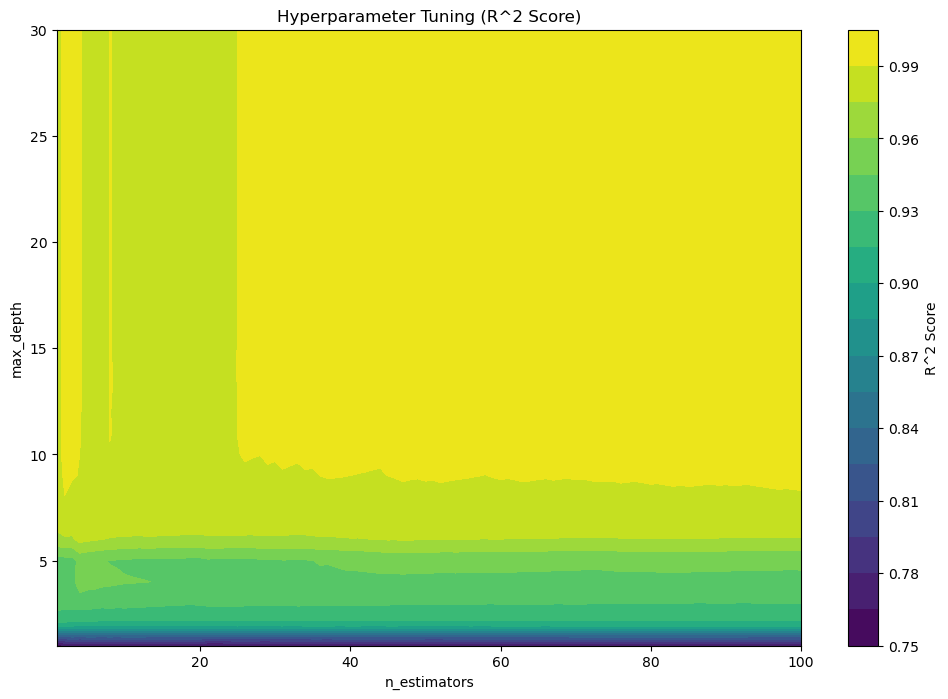

In [13]:
from itertools import product
from joblib import Parallel, delayed
import warnings
import os as os
# Ignore warnings
warnings.filterwarnings('ignore')

# Assume X and y are already defined and loaded
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': range(1, 101, 1),  # From 1 to 100, step size 1
    'max_depth': range(1, 31, 1),       # From 1 to 30, step size 1
    'min_samples_split': range(2, 3, 1)  
}

# Enumerate all hyperparameter combinations
param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['min_samples_split']
))

# Define the training function
def train_and_evaluate(n_estimators, max_depth, min_samples_split, X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize the model
    model = MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
    )
    # Train the model
    model.fit(X_train_scaled, y_train)
    # Calculate the score
    score = model.score(X_test_scaled, y_test)  # Use R^2 as the scoring metric
    # Return 4 values
    return n_estimators, max_depth, min_samples_split, score

# Parallel processing
scores = Parallel(n_jobs=-1, verbose=1)(
    delayed(train_and_evaluate)(n_estimators, max_depth, min_samples_split, X_train_scaled, y_train, X_test_scaled, y_test)
    for n_estimators, max_depth, min_samples_split in param_combinations
)

# Convert to NumPy array
scores_array = np.array(scores)

# Check the shape of scores_array
print("Shape of scores_array:", scores_array.shape)

# Extract unique n_estimators and max_depth values
n_estimators_vals = np.unique(scores_array[:, 0])
max_depth_vals = np.unique(scores_array[:, 1])

# Create a grid
X_grid, Y_grid = np.meshgrid(n_estimators_vals, max_depth_vals)

# Initialize Z value matrix
Z = np.zeros(X_grid.shape)

# Fill the Z matrix
for i, n_estimators in enumerate(n_estimators_vals):
    for j, max_depth in enumerate(max_depth_vals):
        # Select all min_samples_split scores paired with the current n_estimators and max_depth
        relevant_scores = scores_array[
            (scores_array[:, 0] == n_estimators) & (scores_array[:, 1] == max_depth)
        ][:, 3]
        Z[j, i] = np.mean(relevant_scores)  # Use the average score

# Plot the contour plot
plt.figure(figsize=(12, 8))
cp = plt.contourf(X_grid, Y_grid, Z, cmap='viridis', levels=20)  # Draw filled contours
cbar = plt.colorbar(cp)  # Add a color bar
cbar.set_label('R^2 Score')

# Beautify the plot
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('Hyperparameter Tuning (R^2 Score)')

# Save as PDF
# Define the desktop path
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# Save the plot as EPS (vector format for high-quality printing)
plt.savefig(os.path.join(desktop_path, 'contour_plot.eps'), format='eps', dpi=300)

# Save the plot as JPG (raster format for general use)
plt.savefig(os.path.join(desktop_path, 'contour_plot.jpg'), format='jpg', dpi=300)

plt.show()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 181 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 225 tasks      | elapsed:  

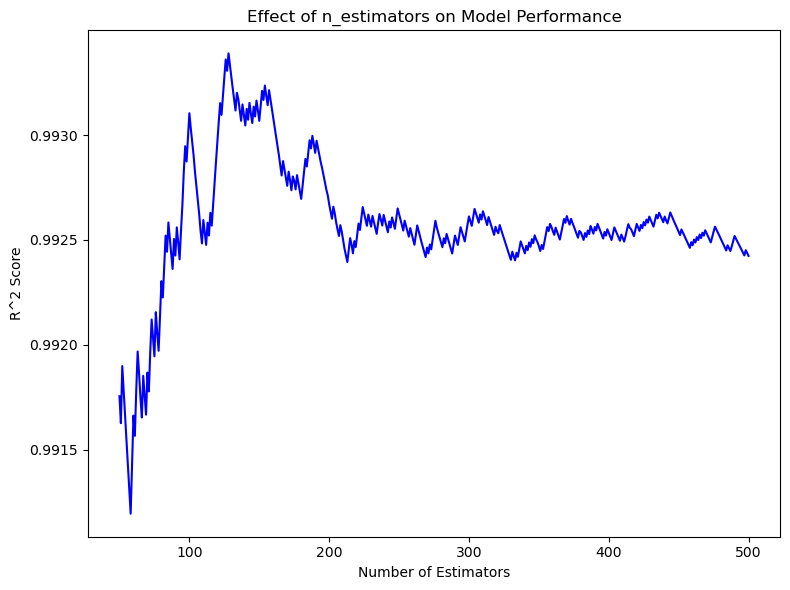

Best n_estimators: 128.0 with R^2 Score: 0.9934


In [14]:
import os  

# Suppress warnings globally
warnings.filterwarnings('ignore')

# Assume X and y are already defined and loaded
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the range for n_estimators (step size of 1)
n_estimators_range = range(50, 501, 1)  # From 50 to 100, step size of 1

# Define the training function
def train_and_evaluate(n_estimators, X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize Random Forest Regressor with MultiOutputRegressor
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=n_estimators, random_state=42))
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)  # Use R^2 as the scoring metric
    return n_estimators, score

# Parallel processing
scores = Parallel(n_jobs=-1, verbose=10)( 
    delayed(train_and_evaluate)(n_estimators, X_train_scaled, y_train, X_test_scaled, y_test)
    for n_estimators in n_estimators_range
)

# Convert to NumPy array for easier processing
scores_array = np.array(scores)

# Extract n_estimators and corresponding scores
n_estimators_vals, n_estimators_scores = scores_array[:, 0], scores_array[:, 1]

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the line graph for n_estimators
plt.plot(n_estimators_vals, n_estimators_scores, color='b')
plt.title('Effect of n_estimators on Model Performance')
plt.xlabel('Number of Estimators')
plt.ylabel('R^2 Score')

# Save the chart as a PDF to the desktop
# Define the desktop path
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# Save the plot as EPS (vector format for high-quality printing)
plt.savefig(os.path.join(desktop_path, 'n_estimators_performance.eps'), format='eps', dpi=300)

# Save the plot as JPG (raster format for general use)
plt.savefig(os.path.join(desktop_path, 'n_estimators_performance.jpg'), format='jpg', dpi=300)
# Display the chart
plt.tight_layout()
plt.show()

# Find the index of the highest R² score
max_score_index = np.argmax(n_estimators_scores)

# Get the corresponding n_estimators value and the highest R² score
best_n_estimators = n_estimators_vals[max_score_index]
best_score = n_estimators_scores[max_score_index]

# Print the results
print(f"Best n_estimators: {best_n_estimators} with R^2 Score: {best_score:.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  46 | elapsed:    0.9s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  17 out of  46 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  22 out of  46 | elapsed:    1.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  27 out of  46 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  32 out of  46 | elapsed:    2.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  37 out of  46 | elapsed:    2.1s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  42 out of  46 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:    2.4s finished


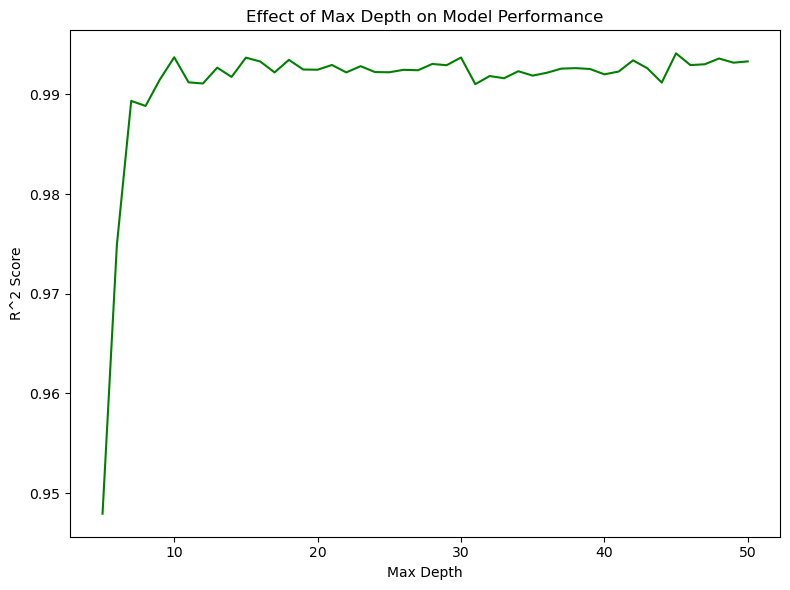

Best Max Depth: 45.0
Best R^2 Score: 0.9941224849196955


In [15]:
# Suppress warnings globally
warnings.filterwarnings('ignore')

# Assume X and y are already defined and loaded
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the range for max_depth (step size of 1)
max_depth_range = range(5, 51, 1)  # From 10 to 30, step size of 1

# Define the training function
def train_and_evaluate(max_depth, X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize Random Forest Regressor with MultiOutputRegressor
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=128, max_depth=max_depth))
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)  # Use R^2 as the scoring metric
    return max_depth, score

# Parallel processing
scores = Parallel(n_jobs=-1, verbose=10)( 
    delayed(train_and_evaluate)(max_depth, X_train_scaled, y_train, X_test_scaled, y_test)
    for max_depth in max_depth_range
)

# Convert to NumPy array for easier processing
scores_array = np.array(scores)

# Extract max_depth and corresponding scores
max_depth_vals, max_depth_scores = scores_array[:, 0], scores_array[:, 1]

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the line graph for max_depth
plt.plot(max_depth_vals, max_depth_scores, color='g')
plt.title('Effect of Max Depth on Model Performance')
plt.xlabel('Max Depth')
plt.ylabel('R^2 Score')

# Save the chart as a PDF to the desktop
# Define the desktop path
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# Save the plot as EPS (vector format for high-quality printing)
plt.savefig(os.path.join(desktop_path, 'max_depth_performance.eps'), format='eps', dpi=300)

# Save the plot as JPG (raster format for general use)
plt.savefig(os.path.join(desktop_path, 'max_depth_performance.jpg'), format='jpg', dpi=300)
# Display the chart
plt.tight_layout()
plt.show()

# Find the index of the highest R² score
best_index = np.argmax(max_depth_scores)

# Get the corresponding max_depth value and the highest R² score
best_max_depth = max_depth_vals[best_index]
best_score = max_depth_scores[best_index]

# Print the results
print(f"Best Max Depth: {best_max_depth}")
print(f"Best R^2 Score: {best_score}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  15 out of  49 | elapsed:    0.7s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done  20 out of  49 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  25 out of  49 | elapsed:    1.1s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  30 out of  49 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  35 out of  49 | elapsed:    1.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  40 out of  49 | elapsed:    1.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  45 out of  49 | elapsed:    1.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  49 out of  49 | elapsed:    1.8s finished


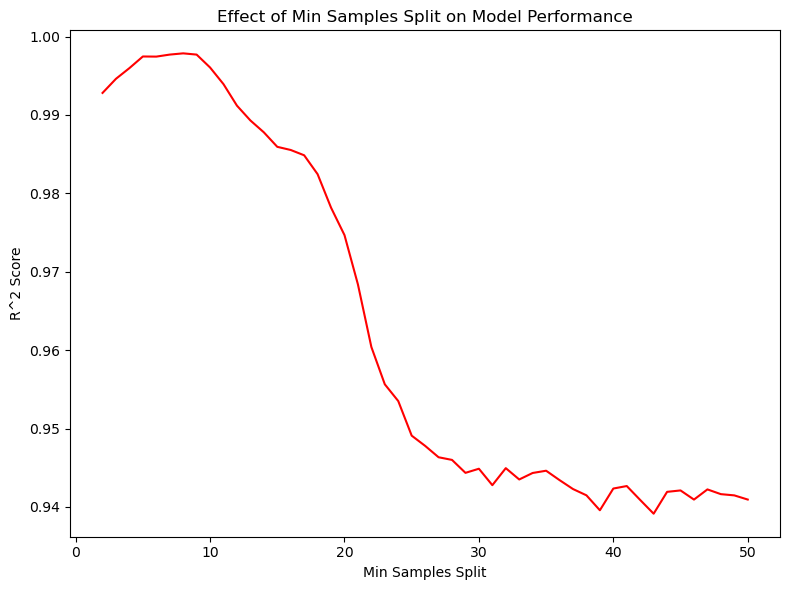

Best Min Samples Split: 8.0
Best R^2 Score: 0.9978572519733905


In [16]:
# Suppress warnings globally
warnings.filterwarnings('ignore')

# Assume X and y are already defined and loaded
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the range for min_samples_split (step size of 1)
min_samples_split_range = range(2, 51, 1)  # From 2 to 10, step size of 1

# Define the training function
def train_and_evaluate(min_samples_split, X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize Random Forest Regressor with MultiOutputRegressor
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=128, max_depth=10, min_samples_split=min_samples_split))
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)  # Use R^2 as the scoring metric
    return min_samples_split, score

# Parallel processing
scores = Parallel(n_jobs=-1, verbose=10)( 
    delayed(train_and_evaluate)(min_samples_split, X_train_scaled, y_train, X_test_scaled, y_test)
    for min_samples_split in min_samples_split_range
)

# Convert to NumPy array for easier processing
scores_array = np.array(scores)

# Extract min_samples_split and corresponding scores
min_samples_split_vals, min_samples_split_scores = scores_array[:, 0], scores_array[:, 1]

# Set the figure size
plt.figure(figsize=(8, 6))

# Plot the line graph for min_samples_split
plt.plot(min_samples_split_vals, min_samples_split_scores, color='r')
plt.title('Effect of Min Samples Split on Model Performance')
plt.xlabel('Min Samples Split')
plt.ylabel('R^2 Score')

# Save the chart as a PDF to the desktop
# Define the desktop path
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# Save the plot as EPS (vector format for high-quality printing)
plt.savefig(os.path.join(desktop_path, 'min_samples_split_performance.eps'), format='eps', dpi=300)

# Save the plot as JPG (raster format for general use)
plt.savefig(os.path.join(desktop_path, 'min_samples_split_performance.jpg'), format='jpg', dpi=300)
# Display the chart
plt.tight_layout()
plt.show()

# Find the index of the highest R² score
best_index = np.argmax(min_samples_split_scores)

# Get the corresponding min_samples_split value and the highest R² score
best_min_samples_split = min_samples_split_vals[best_index]
best_score = min_samples_split_scores[best_index]

# Print the results
print(f"Best Min Samples Split: {best_min_samples_split}")
print(f"Best R^2 Score: {best_score}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed:    0.4s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


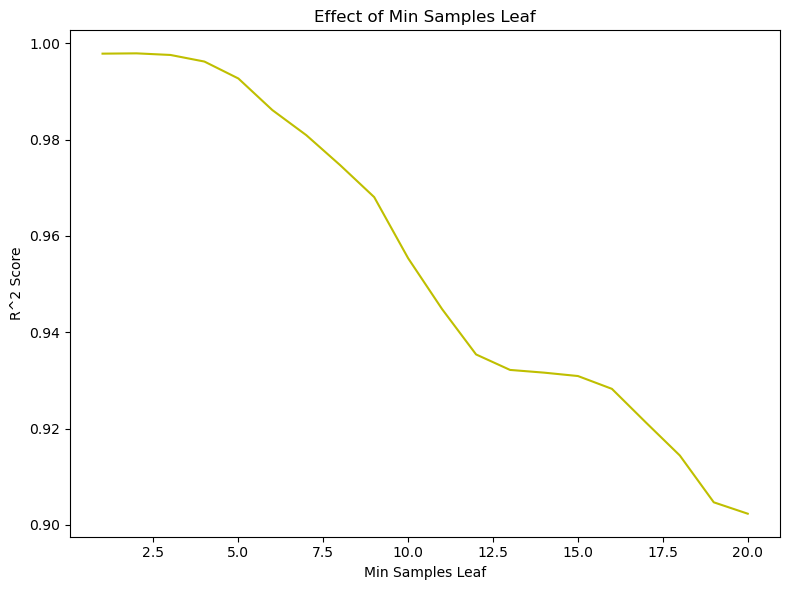

Best Min Samples Leaf: 2.0
Best R^2 Score: 0.9978871430969212


In [17]:
# Suppress warnings globally
warnings.filterwarnings('ignore')

# Assume X and y are already defined and loaded
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Initialize the scaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the range for max_depth (step size of 1)
min_samples_leaf_range = range(1, 21, 1)  

# Define the training function
def train_and_evaluate(min_samples_leaf, X_train_scaled, y_train, X_test_scaled, y_test):
    # Initialize Random Forest Regressor with MultiOutputRegressor
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=128, max_depth=10, min_samples_split=7, min_samples_leaf=min_samples_leaf))
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)  
    return min_samples_leaf, score

# Parallel processing
scores = Parallel(n_jobs=-1, verbose=10)( 
    delayed(train_and_evaluate)(min_samples_leaf, X_train_scaled, y_train, X_test_scaled, y_test)
    for min_samples_leaf in min_samples_leaf_range
)

# Extract min_samples_split and corresponding scores
scores_array = np.array(scores)
min_samples_leaf_vals, min_samples_leaf_scores = zip(*scores_array)

# Plot and Save
plt.figure(figsize=(8, 6))
plt.plot(min_samples_leaf_vals, min_samples_leaf_scores, color='y')
plt.title('Effect of Min Samples Leaf')
plt.xlabel('Min Samples Leaf')
plt.ylabel('R^2 Score')
# Define the desktop path
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# Save the plot as EPS (vector format for high-quality printing)
plt.savefig(os.path.join(desktop_path, 'min_samples_leaf_performance.eps'), format='eps', dpi=300)

# Save the plot as JPG (raster format for general use)
plt.savefig(os.path.join(desktop_path, 'min_samples_leaf_performance.jpg'), format='jpg', dpi=300)
plt.tight_layout()
plt.show()

# Find the index of the highest R² score
best_index = np.argmax(min_samples_leaf_scores)

# Get the corresponding min_samples_leaf value and the highest R² score
best_min_samples_leaf = min_samples_leaf_vals[best_index]
best_score = min_samples_leaf_scores[best_index]

# Print results
print(f"Best Min Samples Leaf: {best_min_samples_leaf}")
print(f"Best R^2 Score: {best_score}")


# 1.2 Neural Network

In [18]:
import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from tqdm import tqdm 
import warnings

warnings.filterwarnings('ignore')

# Define the neural network model
NN_model = models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons and ReLU activation
    layers.Dense(32, activation='relu'),  # Another hidden layer with 32 neurons
    layers.Dense(y_train.shape[1])  # Output layer with the same number of neurons as y_train columns
])

# Compile the model
NN_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
NN_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Predict on the test set
y_pred = NN_model.predict(X_test)

# Check the shape of y_pred
print("Shape of y_pred:", y_pred.shape)

# Create a DataFrame to display results
df_results = pd.DataFrame({
    'PCR - Predicted': y_pred[:, 0],  # First column of y_pred
    'PCR - Actual': y_test.iloc[:, 0],  # First column of y_test
    'Absorption Effect - Predicted': y_pred[:, 1],  # Second column of y_pred
    'Absorption Effect - Actual': y_test.iloc[:, 1]  # Second column of y_test
})

print("Neural Network Prediction Results:")
print(df_results)

# Calculate R² for each output
r2_polarization = r2_score(y_test.iloc[:, 0], y_pred[:, 0])
r2_absorption = r2_score(y_test.iloc[:, 1], y_pred[:, 1])

# Print R² values
print(f"R² for Polarization Effect: {r2_polarization}")
print(f"R² for Absorption Effect: {r2_absorption}")

# Define input ranges and step sizes
input_ranges = [
    (11, 20, 0.5),
    (10, 20, 0.5),
    (9, 10, 1),
    (8, 9, 1),
    (1, 2, 0.01),
    (16, 18, 0.1)
]

def generate_input_combinations(input_ranges):
    """Use a generator to gradually generate input combinations to reduce memory usage"""
    ranges = [np.arange(start, end + step, step) for start, end, step in input_ranges]
    for combination in np.nditer(np.meshgrid(*ranges, indexing='ij')):
        yield combination

def batch_predict(inputs_batch, model, scaler):
    """Batch predict inputs and return results"""
    inputs_scaled = scaler.transform(inputs_batch)
    predictions = model.predict(inputs_scaled)
    return predictions

# Initialize optimal variables
best_input = None
best_output = None
best_sum = -np.inf

# Store all calculated PCR and Absorption values
pcr_values = []
absorption_values = []
input_combinations = []

# Batch processing size
batch_size = 1000
input_batch = []
combination_num = 0

# Calculate total number of combinations
ranges = [np.arange(start, end + step, step) for start, end, step in input_ranges]
total_combinations = np.prod([len(r) for r in ranges])

# Adjust batch_size and tqdm update frequency
batch_size = 10000  # Increase batch_size
update_freq = 100000  # Update progress bar every 1000 combinations

with tqdm(total=total_combinations, desc="Processing Progress", mininterval=1) as pbar:
    input_batch = []
    for i, combination in enumerate(generate_input_combinations(input_ranges)):
        input_batch.append(combination)
        
        # Update progress bar every update_freq combinations
        if i % update_freq == 0:
            pbar.update(update_freq)
        
        # Perform prediction when batch_size is reached
        if len(input_batch) >= batch_size:
            inputs_array = np.array(input_batch)
            predictions = batch_predict(inputs_array, NN_model, scaler)
            
            # Process predictions
            for j, prediction in enumerate(predictions):
                pcr_values.append(prediction[0])
                absorption_values.append(prediction[1])
                
                output_sum = prediction[0] + prediction[1]
                if output_sum > best_sum:
                    best_sum = output_sum
                    best_input = inputs_array[j]
                    best_output = prediction
            
            input_batch = []  # Clear batch

    # Process remaining input combinations
    if input_batch:
        inputs_array = np.array(input_batch)
        predictions = batch_predict(inputs_array, NN_model, scaler)
        
        for j, prediction in enumerate(predictions):
            pcr_values.append(prediction[0])
            absorption_values.append(prediction[1])
            
            output_sum = prediction[0] + prediction[1]
            if output_sum > best_sum:
                best_sum = output_sum
                best_input = inputs_array[j]
                best_output = prediction

# Output results
print("\n🔹 Best Input Feature Combination:")
print(best_input)

# Output prediction results
print("\n🔹 Predicted Results for Best Input:")
print(f"📊 PCR Predicted Value: {best_output[0]}")
print(f"📊 Absorption Predicted Value: {best_output[1]}")

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 40.5115 - val_loss: 4.2232
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0950 - val_loss: 0.9954
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1121 - val_loss: 0.4778
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4044 - val_loss: 0.4291
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4272 - val_loss: 0.3639
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3659 - val_loss: 0.3445
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3539 - val_loss: 0.3313
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3074 - val_loss: 0.3175
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3121 - val_loss: 0.2995
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3154 - val_loss: 0.2878
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2622 - val_loss: 0.2759
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0

Processing Progress:   0%|          | 0/3546312 [00:00<?, ?it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:   6%|▌         | 200000/3546312 [00:08<02:26, 22913.10it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:   8%|▊         | 300000/3546312 [00:17<03:20, 16214.00it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  11%|█▏        | 400000/3546312 [00:26<03:42, 14112.39it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  14%|█▍        | 500000/3546312 [00:34<03:51, 13186.68it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  17%|█▋        | 600000/3546312 [00:43<03:53, 12600.89it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  20%|█▉        | 700000/3546312 [00:52<03:55, 12098.99it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  23%|██▎       | 800000/3546312 [01:01<03:55, 11637.52it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Processing Progress:  25%|██▌       | 900000/3546312 [01:11<03:56, 11208.25it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  28%|██▊       | 1000000/3546312 [01:20<03:50, 11040.11it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  31%|███       | 1100000/3546312 [01:29<03:44, 10908.91it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  34%|███▍      | 1200000/3546312 [01:39<03:36, 10840.20it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  37%|███▋      | 1300000/3546312 [01:48<03:26, 10855.69it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  39%|███▉      | 1400000/3546312 [01:57<03:18, 10792.62it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  42%|████▏     | 1500000/3546312 [02:07<03:10, 10770.03it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  45%|████▌     | 1600000/3546312 [02:15<02:57, 10983.05it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  48%|████▊     | 1700000/3546312 [02:24<02:44, 11210.77it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  51%|█████     | 1800000/3546312 [02:32<02:33, 11411.05it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  54%|█████▎    | 1900000/3546312 [02:41<02:24, 11373.93it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  56%|█████▋    | 2000000/3546312 [02:50<02:15, 11434.86it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  59%|█████▉    | 2100000/3546312 [02:58<02:04, 11659.69it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  62%|██████▏   | 2200000/3546312 [03:06<01:54, 11778.55it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  65%|██████▍   | 2300000/3546312 [03:15<01:46, 11694.99it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  68%|██████▊   | 2400000/3546312 [03:24<01:38, 11592.94it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  70%|███████   | 2500000/3546312 [03:33<01:32, 11357.22it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  73%|███████▎  | 2600000/3546312 [03:42<01:24, 11143.11it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  76%|███████▌  | 2700000/3546312 [03:52<01:16, 11015.37it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1485s 5s/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  76%|███████▌  | 2700000/3546312 [28:42<01:16, 11015.37it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  79%|███████▉  | 2800000/3546312 [28:46<56:33, 219.92it/s]  

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  82%|████████▏ | 2900000/3546312 [28:55<34:34, 311.50it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  85%|████████▍ | 3000000/3546312 [29:04<20:42, 439.56it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  87%|████████▋ | 3100000/3546312 [29:13<12:02, 617.66it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  90%|█████████ | 3200000/3546312 [29:22<06:41, 862.65it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  93%|█████████▎| 3300000/3546312 [29:31<03:26, 1191.60it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  96%|█████████▌| 3400000/3546312 [29:40<01:29, 1626.57it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress:  99%|█████████▊| 3500000/3546312 [29:50<00:21, 2183.14it/s]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Processing Progress: 3600000it [29:59, 2871.77it/s]                             

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing Progress: 3600000it [30:03, 1995.99it/s]


🔹 Best Input Feature Combination:
[12.  10.  10.   8.   2.  16.3]

🔹 Predicted Results for Best Input:
📊 PCR Predicted Value: 0.613832414150238
📊 Absorption Predicted Value: 0.3836152255535126


# 1.3 KNN

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from tqdm import tqdm 
import warnings

warnings.filterwarnings('ignore')

# Initialize the K-Nearest Neighbors regressor for multi-output regression
n_neighbors = 5
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the test set
y_pred3 = knn.predict(X_test)

# Create a DataFrame to display predicted vs. actual values
df_results3 = pd.DataFrame({
    'Polarization Effect - Predicted': y_pred3[:, 0],  
    'Polarization Effect - Actual': y_test.iloc[:, 0],  
    'Absorption Effect - Predicted': y_pred3[:, 1],  
    'Absorption Effect - Actual': y_test.iloc[:, 1] 
})
print("KNN")
print(df_results3)

# Calculate R² for each output
r2_polarization3 = r2_score(y_test.iloc[:, 0], y_pred3[:, 0])  # Use y_pred3 instead of y_pred
r2_absorption3 = r2_score(y_test.iloc[:, 1], y_pred3[:, 1])    # Use y_pred3 instead of y_pred

# Print R² values
print(f"R² for Polarization Effect: {r2_polarization3}")
print(f"R² for Absorption Effect: {r2_absorption3}")

# Define input ranges and step sizes
input_ranges = [
    (11, 20, 0.5),
    (10, 20, 0.5),
    (9, 10, 1),
    (8, 9, 1),
    (1, 2, 0.01),
    (16, 18, 0.1)
]

def generate_input_combinations(input_ranges):
    """Use a generator to gradually generate input combinations to reduce memory usage"""
    ranges = [np.arange(start, end + step, step) for start, end, step in input_ranges]
    for combination in np.nditer(np.meshgrid(*ranges, indexing='ij')):
        yield combination

def batch_predict(inputs_batch, model, scaler):
    """Batch predict inputs and return results"""
    inputs_scaled = scaler.transform(inputs_batch)
    predictions = model.predict(inputs_scaled)
    return predictions

# Initialize optimal variables
best_input = None
best_output = None
best_sum = -np.inf

# Store all calculated PCR and Absorption values
pcr_values = []
absorption_values = []
input_combinations = []

# Batch processing size
batch_size = 1000
input_batch = []
combination_num = 0

# Calculate total number of combinations
ranges = [np.arange(start, end + step, step) for start, end, step in input_ranges]
total_combinations = np.prod([len(r) for r in ranges])

# Use tqdm to display a progress bar
with tqdm(total=total_combinations, desc="Processing Progress") as pbar:
    for combination in generate_input_combinations(input_ranges):
        input_batch.append(combination)
        input_combinations.append(combination)
        combination_num += 1

        # Update progress bar
        pbar.update(1)

        # Perform prediction when batch size is reached
        if len(input_batch) >= batch_size:
            inputs_array = np.array(input_batch)
            predictions = batch_predict(inputs_array, knn, scaler)

            # Store prediction results
            for i, prediction in enumerate(predictions):
                pcr_values.append(prediction[0])
                absorption_values.append(prediction[1])

                output_sum = prediction[0] + prediction[1]
                if output_sum > best_sum:
                    best_sum = output_sum
                    best_input = inputs_array[i]
                    best_output = prediction

            input_batch = []

    # Process remaining input combinations
    if input_batch:
        inputs_array = np.array(input_batch)
        predictions = batch_predict(inputs_array, knn, scaler)

        for i, prediction in enumerate(predictions):
            pcr_values.append(prediction[0])
            absorption_values.append(prediction[1])

            output_sum = prediction[0] + prediction[1]
            if output_sum > best_sum:
                best_sum = output_sum
                best_input = inputs_array[i]
                best_output = prediction

# Output results
print("\n🔹 Best Input Feature Combination:")
print(best_input)

# Output prediction results
print("\n🔹 Predicted Results for Best Input:")
print(f"📊 PCR Predicted Value: {best_output[0]}")
print(f"📊 Absorption Predicted Value: {best_output[1]}")

KNN
     Polarization Effect - Predicted  Polarization Effect - Actual  \
517                           2.9484                         3.182   
6                             2.4714                         2.066   
322                           3.6314                         3.592   
416                           3.5704                         3.564   
497                           3.6636                         3.784   
185                           3.0016                         3.079   
75                            2.1858                         1.970   
104                           2.1920                         1.993   
180                           2.8484                         3.058   
403                           3.5786                         3.578   
530                           3.1356                         3.185   
457                           3.4612                         3.565   
10                            2.6610                         2.056   
238             

Processing Progress: 100%|██████████| 3546312/3546312 [00:28<00:00, 123798.58it/s]


🔹 Best Input Feature Combination:
[11. 10.  9.  8.  1. 16.]

🔹 Predicted Results for Best Input:
📊 PCR Predicted Value: 2.6282000000000005
📊 Absorption Predicted Value: 0.9376000000000001


In [20]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from tqdm import tqdm 
import warnings

warnings.filterwarnings('ignore')

# Initialize the SVM regressor for multi-output regression
svm = MultiOutputRegressor(SVR())  # You can adjust hyperparameters like kernel, C, etc.

# Fit the model to the training data
svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm.predict(X_test)

# Create a DataFrame to display predicted vs. actual values
df_results_svm = pd.DataFrame({
    'Polarization Effect - Predicted': y_pred_svm[:, 0],  
    'Polarization Effect - Actual': y_test.iloc[:, 0],  
    'Absorption Effect - Predicted': y_pred_svm[:, 1],  
    'Absorption Effect - Actual': y_test.iloc[:, 1] 
})
print("SVM")
print(df_results_svm)

# Calculate R² for each output
r2_polarization_svm = r2_score(y_test.iloc[:, 0], y_pred_svm[:, 0])
r2_absorption_svm = r2_score(y_test.iloc[:, 1], y_pred_svm[:, 1])

# Print R² values
print(f"R² for Polarization Effect: {r2_polarization_svm}")
print(f"R² for Absorption Effect: {r2_absorption_svm}")

# Define input ranges and step sizes
input_ranges = [
    (11, 20, 0.5),
    (10, 20, 0.5),
    (9, 10, 1),
    (8, 9, 1),
    (1, 2, 0.01),
    (16, 18, 0.1)
]

def generate_input_combinations(input_ranges):
    """Use a generator to gradually generate input combinations to reduce memory usage"""
    ranges = [np.arange(start, end + step, step) for start, end, step in input_ranges]
    for combination in np.nditer(np.meshgrid(*ranges, indexing='ij')):
        yield combination

def batch_predict(inputs_batch, model, scaler):
    """Batch predict inputs and return results"""
    inputs_scaled = scaler.transform(inputs_batch)
    predictions = model.predict(inputs_scaled)
    return predictions

# Initialize optimal variables
best_input = None
best_output = None
best_sum = -np.inf

# Store all calculated PCR and Absorption values
pcr_values = []
absorption_values = []
input_combinations = []

# Batch processing size
batch_size = 1000
input_batch = []
combination_num = 0

# Calculate total number of combinations
ranges = [np.arange(start, end + step, step) for start, end, step in input_ranges]
total_combinations = np.prod([len(r) for r in ranges])

# Use tqdm to display a progress bar
with tqdm(total=total_combinations, desc="Processing Progress") as pbar:
    for combination in generate_input_combinations(input_ranges):
        input_batch.append(combination)
        input_combinations.append(combination)
        combination_num += 1

        # Update progress bar
        pbar.update(1)

        # Perform prediction when batch size is reached
        if len(input_batch) >= batch_size:
            inputs_array = np.array(input_batch)
            predictions = batch_predict(inputs_array, svm, scaler)

            # Store prediction results
            for i, prediction in enumerate(predictions):
                pcr_values.append(prediction[0])
                absorption_values.append(prediction[1])

                output_sum = prediction[0] + prediction[1]
                if output_sum > best_sum:
                    best_sum = output_sum
                    best_input = inputs_array[i]
                    best_output = prediction

            input_batch = []

    # Process remaining input combinations
    if input_batch:
        inputs_array = np.array(input_batch)
        predictions = batch_predict(inputs_array, svm, scaler)

        for i, prediction in enumerate(predictions):
            pcr_values.append(prediction[0])
            absorption_values.append(prediction[1])

            output_sum = prediction[0] + prediction[1]
            if output_sum > best_sum:
                best_sum = output_sum
                best_input = inputs_array[i]
                best_output = prediction

# Output results
print("\n🔹 Best Input Feature Combination:")
print(best_input)

# Output prediction results
print("\n🔹 Predicted Results for Best Input:")
print(f"📊 PCR Predicted Value: {best_output[0]}")
print(f"📊 Absorption Predicted Value: {best_output[1]}")

SVM
     Polarization Effect - Predicted  Polarization Effect - Actual  \
517                         2.409081                         3.182   
6                           2.303096                         2.066   
322                         3.664706                         3.592   
416                         3.582421                         3.564   
497                         3.319143                         3.784   
185                         2.941581                         3.079   
75                          2.154962                         1.970   
104                         2.095273                         1.993   
180                         2.952851                         3.058   
403                         3.633019                         3.578   
530                         2.410482                         3.185   
457                         3.504940                         3.565   
10                          2.369803                         2.056   
238             

Processing Progress: 100%|██████████| 3546312/3546312 [04:53<00:00, 12097.58it/s]


🔹 Best Input Feature Combination:
[11. 10.  9.  8.  1. 16.]

🔹 Predicted Results for Best Input:
📊 PCR Predicted Value: 2.3261933661910428
📊 Absorption Predicted Value: 0.0809563952528535
